In [1]:
import os
import sys
import gzip
import gpxpy
import shutil
import fitdecode
import gpxpy.gpx
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

strava_export = "c:\\Users\\matti\\Desktop\\Garmin IQ datafield\\export_105647830\\activities"

import parse_fit
import parse_gpx
import parse_tcx

pd.options.display.max_columns = 100

%load_ext autoreload
%autoreload 2

https://towardsdatascience.com/parsing-fitness-tracker-data-with-python-a59e7dc17418

In [2]:
###########################################
####### GET DATA COMPUTED BY STRAVA #######
###########################################

activies_df = pd.read_csv(strava_export + ".csv")
activies_df["Filename"] = activies_df["Filename"].apply(lambda v: v if pd.isnull(v)
                                                        else v.split("/")[1].replace(".gz", ""))

```python
#######################
### UNZIP ALL FILES ###
#######################
for filename in os.listdir(strava_export):
    if filename.endswith('.gz') and filename.replace(".gz", "") not in os.listdir(strava_export): 
    print(filename)
    with gzip.open("\\".join((strava_export, filename)), 'rb') as f_in:
        with open("\\".join((strava_export, filename))[:-3], 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
```

In [3]:
list_of_fit_files = ["\\".join((strava_export, v)) for v in os.listdir(strava_export)
                     if ".gpx" not in v and ".gz" not in v]
list_of_gpx_files = ["\\".join((strava_export, v)) for v in os.listdir(strava_export)
                     if ".gpx" in v]

In [4]:
##########################################
### GET TO DATAFRAME PER EACH FIT FILE ###
##########################################
list_of_dfs_fit_points = []
list_of_dfs_fit_laps = []
for file in tqdm(list_of_fit_files):
    d_ = parse_fit.get_dataframes(file)
    list_of_dfs_fit_laps.append(d_[0])
    list_of_dfs_fit_points.append(d_[1])

fit_file_laps = pd.concat(list_of_dfs_fit_laps, ignore_index = True)
fit_file_points = pd.concat(list_of_dfs_fit_points, ignore_index = True)

100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [05:44<00:00,  2.94s/it]
C:\Users\matti\AppData\Local\Temp\ipykernel_22392\4025744445.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fit_file_laps = pd.concat(list_of_dfs_fit_laps, ignore_index = True)
C:\Users\matti\AppData\Local\Temp\ipykernel_22392\4025744445.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fit_file_points = pd.concat(list_of_dfs_fit_points, ignore_index = True)


In [11]:
sorted(activies_df["Activity Name"])[::-1][:10]

['Zwift - Zwift Academy: Workout 1 | Explosive 30s in Yorkshire',
 'Zwift - Zwift Academy Tri:  Bike Workout 2 | Aerobic Threshold Development in Watopia',
 'Zwift - Zone 3 Steps in Makuri Islands',
 'Zwift - Zone 1 Ride in Innsbruck',
 'Zwift - Workout 13 in New York',
 'Zwift - Volcano Climb Forward in Watopia',
 'Zwift - Triple Flat Loops in Watopia',
 'Zwift - Tiny Race: Seaside Sprint in Watopia',
 'Zwift - Threshold Development in France',
 'Zwift - Threshold #2 in Watopia']

In [5]:
activies_df[activies_df["Activity Name"] == "Zwift - The Pretzel in Watopia"]

,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,Activity Private Note,Activity Gear,Filename,Athlete Weight,Bike Weight,Elapsed Time.1,Moving Time,Distance.1,Max Speed,Average Speed,Elevation Gain,Elevation Loss,Elevation Low,Elevation High,Max Grade,Average Grade,Average Positive Grade,Average Negative Grade,Max Cadence,Average Cadence,Max Heart Rate.1,Average Heart Rate,Max Watts,Average Watts,Calories,Max Temperature,Average Temperature,Relative Effort.1,Total Work,Number of Runs,Uphill Time,Downhill Time,Other Time,Perceived Exertion,Type,Start Time,Weighted Average Power,Power Count,Prefer Perceived Exertion,Perceived Relative Effort,Commute.1,Total Weight Lifted,From Upload,Grade Adjusted Distance,Weather Observation Time,Weather Condition,Weather Temperature,Apparent Temperature,Dewpoint,Humidity,Weather Pressure,Wind Speed,Wind Gust,Wind Bearing,Precipitation Intensity,Sunrise Time,Sunset Time,Moon Phase,Bike,Gear,Precipitation Probability,Precipitation Type,Cloud Cover,Weather Visibility,UV Index,Weather Ozone,Jump Count,Total Grit,Average Flow,Flagged,Average Elapsed Speed,Dirt Distance,Newly Explored Distance,Newly Explored Dirt Distance,Activity Count,Total Steps,Carbon Saved,Pool Length,Training Load,Intensity,Average Grade Adjusted Pace,Timer Time,Total Cycles,Media
132,11659433168,"Jun 15, 2024, 1:19:44 PM",Zwift - The Pretzel in Watopia,Virtual Ride,Ride to improve PBs on hills,11086,73.07,186.0,202.0,False,NaN,Scott Addict RC (virtual),12441011297.fit,NaN,7.9,11086.0,10407.0,73076.007812,24.015625,7.021813,1354.0,0.0,-6.4,516.200012,19.785538,-0.007937,NaN,NaN,114.0,87.526077,186.0,157.124146,NaN,144.016159,1431.0,NaN,NaN,202.0,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,155.0,10660.0,0.0,274.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13940951.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,6.591738,0.0,NaN,NaN,NaN,NaN,NaN,NaN,219.0,86.0,NaN,NaN,NaN,media/c67ff196-d530-4e92-a210-242434894968.jpg...


In [71]:
def preprocessing(lst):
    
    out = []
    for d in lst:
        if d["power"].isnull().sum() == 0:
            # print(d["FileName"].values[0])        
            valeria = d.copy().reset_index(drop = True)
            valeria["heart_rate"] = valeria["heart_rate"].astype(int)
            valeria["grade"] = (100*(valeria["altitude"].diff().fillna(0)/valeria["distance"].diff().fillna(0)).fillna(0))
            valeria = valeria.dropna(axis = 1, how = "all")
            valeria = valeria.sort_values("timestamp").reset_index(drop = True)

            valeria_3s = valeria.set_index("timestamp").drop("FileName", axis = 1).resample('5s', offset="0.1s",
                                                                                            origin = "start").mean()
            valeria_3s = valeria_3s.dropna(how = "all")
            valeria_3s = valeria_3s[valeria_3s["power"] > 0].reset_index(drop = True)

            out += [valeria_3s]
        
    return pd.concat(out, ignore_index = True)

In [69]:
# list_of_dfs_fit_points[0].head()

In [72]:
Xy = preprocessing(list_of_dfs_fit_points)
Xy[Xy["grade"] > 30] = 10
Xy[Xy["grade"] < -30] = -10

In [38]:
# example = fit_file_points[fit_file_points["FileName"] == "12441011297.fit"].copy().reset_index(drop = True)
# example["heart_rate"] = example["heart_rate"].astype(int)
# example["grade"] = (100*(example["altitude"].diff().fillna(0)/example["distance"].diff().fillna(0)).fillna(0))
# example = example.dropna(axis=1, how = "all")
# example = example.sort_values("timestamp").reset_index(drop = True)

In [73]:
# fit_file_points[fit_file_points["FileName"] == "12441011297.fit"].copy().reset_index(drop = True).head()

In [74]:
# example_3s =example.set_index("timestamp").drop("FileName", axis = 1).resample('5s', offset="0.1s",  origin = "start").mean()
# example_3s = example_3s.dropna(how = "all")

In [75]:
# example_3s

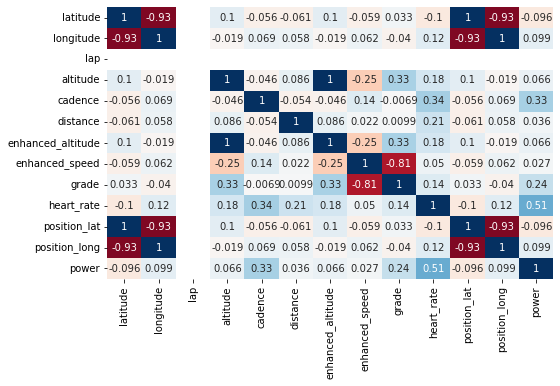

In [78]:
plt.figure(figsize = (8, 5))
sns.heatmap(Xy.corr(), vmin = -1, vmax = 1, cbar = False, annot = True, cmap = "RdBu")
plt.show()

In [91]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

X = Xy[["heart_rate", "enhanced_speed", "cadence", "grade"]].copy()
y = Xy["power"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle = True)

lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
print(lr.coef_, lr.intercept_)

[0.84102769 5.66703562 0.66008618 6.34528534] -99.51375076671715


In [92]:
lr_preds = pd.DataFrame({"y_true": y_test, "y_pred": lr.predict(X_test)})
lr_preds["delta"] = abs(lr_preds["y_true"] - lr_preds["y_pred"])

<AxesSubplot:>

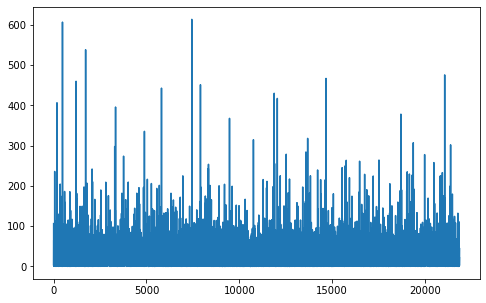

In [93]:
plt.figure(figsize = (8, 5))
lr_preds["delta"].reset_index(drop = True).plot()

<AxesSubplot:>

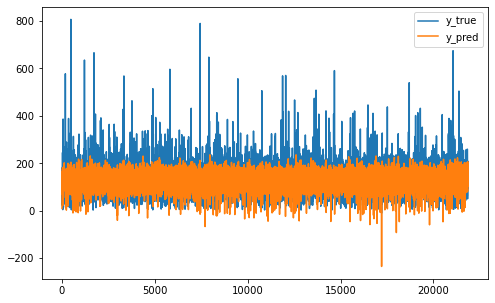

In [94]:
fix, ax = plt.subplots(1, 1, figsize = (8, 5))
lr_preds.reset_index(drop = True).drop("delta", axis = 1).plot(ax = ax)

In [95]:
print("R^2: {:.2f}".format(r2_score(y_test, lr.predict(X_test))))
print("RMSE: {:.2f}".format(mean_squared_error(y_test, lr.predict(X_test), squared=False)))
print("MAE: {:.2f}".format(mean_absolute_error(y_test, lr.predict(X_test))))
print("MAPE: {:.2f} %".format(100*mean_absolute_percentage_error(y_test, lr.predict(X_test))))

R^2: 0.38
RMSE: 37.07
MAE: 24.16
MAPE: 26.65 %


In [49]:
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.python.framework.random_seed import set_random_seed

In [96]:
model = Sequential()
model.add(Dense(input_dim = 4, units = 4, activation = "elu"))
model.add(Dense(units = 4, activation = "elu"))
model.add(Dense(units = 4, activation = "elu"))
model.add(Dense(units = 1, activation = None))
model.compile(loss = "mean_absolute_error", optimizer = "adam",
              metrics = ["mean_absolute_error", "mean_absolute_percentage_error"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 4)                 20        
                                                                 
 dense_8 (Dense)             (None, 4)                 20        
                                                                 
 dense_9 (Dense)             (None, 4)                 20        
                                                                 
 dense_10 (Dense)            (None, 1)                 5         
                                                                 
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________


In [97]:
## Define an Early Stopping
early_stopping = EarlyStopping(monitor = "mean_absolute_error", mode = "min", patience = 20, verbose = 1)

history = model.fit(X_train, y_train, epochs = 1000, batch_size = 100,
                    verbose = 0, validation_split = 0.4, callbacks = [early_stopping])

Epoch 304: early stopping


<AxesSubplot:>

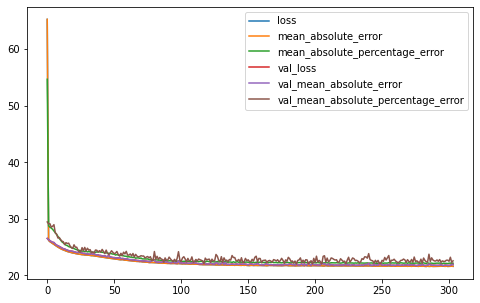

In [98]:
pd.DataFrame(history.history).plot(figsize = (8, 5))

In [99]:
print("RMSE: {:.2f}".format(mean_squared_error(y_test, model.predict(X_test), squared=False)))
print("MAE: {:.2f}".format(mean_absolute_error(y_test, model.predict(X_test))))
print("MAPE: {:.2f} %".format(100*mean_absolute_percentage_error(y_test, model.predict(X_test))))

683/683 [==============================] - 1s 1ms/step
RMSE: 34.67
683/683 [==============================] - 1s 1ms/step
MAE: 21.97
683/683 [==============================] - 1s 2ms/step
MAPE: 22.81 %


$POWER=\frac{9\cdot(6\cdot A\cdot R-b\cdot c)}{26.46\cdot a}$

$R=$

$9^{\frac{1}{3}}$

$x=\frac{1}{1157360400a^3}*[\frac{}{50^{\frac{2}{3}}}-\frac{}{50^{\frac{1}{3}}}+11809799900\cdot a^3\cdot s^3+a^2\cdot b\cdot(11809799900\cdot s^2 - 3936600000\cdot c)+3936599980\cdot a\cdot b^2 \cdot s + 437399997\cdot b^3]$

```python
##########################################
### GET TO DATAFRAME PER EACH GPX FILE ###
##########################################

list_of_dfs_gpx = []
for file in list_of_gpx_files:
    try:
        d_ = parse_gpx.get_dataframe_from_gpx(file)
        list_of_dfs_gpx.append(d_)
    except Exception as e:
        print(file)

list_of_dfs_gpx[0]

from lxml.etree import tostring

gpx = gpxpy.parse(open("\\".join((strava_export, "7501129268.gpx")), 'r'))

print(len(gpx.tracks))
for track in gpx.tracks:
    print(len(track.segments))
    for segment in track.segments:
        print(len(segment.points))
        for point in segment.points:
            
            #print(point.attributes)

            print({'latitude': point.latitude,
            'longitude': point.longitude,
            'elevation': point.elevation,
            'time': point.time,
            'speed': point.speed})
            # print(tostring(point.extensions[0]))
            # # for df in []:
            # #     print(elem.find(f'garmin_tpe:{df}', NAMESPACES).text)


            # NAMESPACES = {'garmin_tpe': 'http://www.garmin.com/xmlschemas/TrackPointExtension/v1'}
            # print(point.extensions[0].find('garmin_tpe:speed', NAMESPACES).text)
```